# Overview: Clustering with PCA and scaling

This practical will demonstrate how important dimensionality resuction can be in terms of cleaning data, and go over standardizing and normalizing data.. 

1: You will see how to standardize and normalize data. 

2: You will learn how to apply PCA.

3: Assess improvement in application of k-Means for standardized and normalizeed data with PCA applied.



### Standardization

Standardizing (or Z-score normalization) refers to rescaling features to have the properties of a normal distribution. This is not only important for features with different units, but also for many algorithms that assume an underlying normal distribution (Euclidian distance measures). The mean ($\mu$) and standard deviation ($\sigma$) should be 0 and 1 respectively. Scores (or z-scores) for the samples "x" are:

$$z=\dfrac{x-\mu}{\sigma}$$


### Normalization/Min-Max scaling

As opposed to standardization, the Min-Max scaling does not center the data around zero (the name is misleading), but scales the data to a fixed range e.g. between 0 and 1. A bounded range will end up with smalled standard deviations. For the data x:

$$x_{norm} = \dfrac{x-x_{min}}{x_{max}-x_{min}}$$


### Which to chose?

Be aware of what your algorithm requires to succeed. Min-Max scaling is very useful in image processing. For PCA we are looking to find the components of maximal variance, so Min-Max scaling is less useful. 

## Practical

Let's load some data freely available online. I am assuming everyone has access to WiFi.

In [41]:
#Reading in the dataset
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

#Here we use pandas 
df = pd.io.parsers.read_csv(
    'https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/wine_data.csv',
    header=None)

URLError: <urlopen error [Errno -2] Name or service not known>

The data is pre-labelled. It happens to be a bunch of wine info, but please excuse this, there was some time pressure.

In [42]:
X = df.values[:,1:]
y = df.values[:,0]

print('The data has three classes 1, 2 and 3, and 178 data points. The X is a matrix: ', 
      X.shape, 'while the classes are a vector with length ', y.shape)

The data has three classes 1, 2 and 3, and 178 data points. The X is a matrix:  (178, 13) while the classes are a vector with length  (178,)


The data is measured on different scales, so we standardize:

In [43]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

Now we use PCA to reduce the dimensionality and supress noise on the standardized as well as the original non-standardized data.

In [44]:
from sklearn.decomposition import PCA

# With non-standardized data
pca = PCA(n_components=2).fit(X)
X = pca.transform(X)

# With standardized data
pca_std = PCA(n_components=2).fit(X_std)
X_std = pca_std.transform(X_std)

#NOTE: Using PCA in practice, always assess how 
#much of the total variance the components a
#ccount for to decide how many are nessesairy.

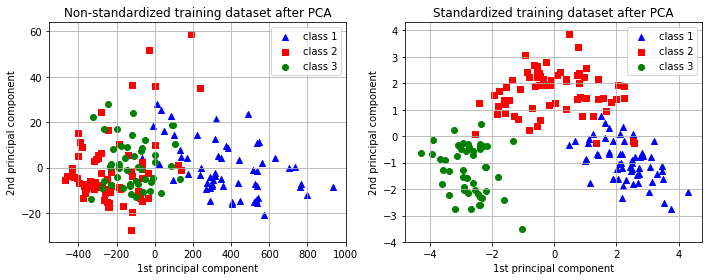

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))


for l,c,m in zip(range(1,4), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X[y==l, 0], X[y==l, 1],
        color=c,
        label='class %s' %l,
        alpha=1,
        marker=m
        )

for l,c,m in zip(range(1,4), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(X_std[y==l, 0], X_std[y==l, 1],
        color=c,
        label='class %s' %l,
        alpha=1,
        marker=m
        )

ax1.set_title('Non-standardized training dataset after PCA')    
ax2.set_title('Standardized training dataset after PCA')    

for ax in (ax1, ax2):

    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()
plt.tight_layout()

plt.show()  

### Things to notice:

We went from an 173x13 dataset to one with only 173x2. Standardizing made the data spread much clearer (contrast left figure to right where the red, blue and green classes are well seperated). Note also the difference in the axes in range and how they are centered around zero to the right.

### K-means test

How well would either dataset do with cluster analysis where we don't know the labels? 

In [46]:
from sklearn import mixture

repeats = 10
kClusters = 10
data = X

criteriaAIC_BIC = np.zeros((repeats,2,kClusters))
for rep in np.arange(0,repeats):
    for nr in np.arange(1,kClusters):
        n_clusters=nr
        data
        model=mixture.GaussianMixture(n_components=n_clusters, init_params='kmeans')
        model.fit(data)
        criteriaAIC_BIC[rep,0,nr]=model.aic(data)
        criteriaAIC_BIC[rep,1,nr]=model.bic(data)

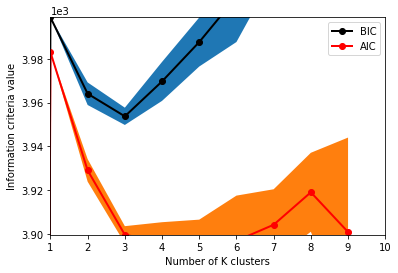

In [49]:
meanAIC = criteriaAIC_BIC[:, 0, 0:kClusters].mean(axis = 0)
stdAIC = criteriaAIC_BIC[:, 0, 0:kClusters].std(axis = 0)

meanBIC = criteriaAIC_BIC[:, 1, 0:kClusters].mean(axis = 0)
stdBIC = criteriaAIC_BIC[:, 1, 0:kClusters].std(axis = 0)

plt.plot(np.arange(0, kClusters),meanBIC, '-ok', label='BIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanBIC-2*stdBIC, meanBIC+2*stdBIC)

plt.plot(np.arange(0, kClusters),meanAIC, '-or', label='AIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanAIC-2*stdAIC, meanAIC+2*stdAIC)


plt.ylim(np.min(meanAIC[1:4]), np.max(meanBIC[0:4]))
plt.xlabel('Number of K clusters')
plt.ylabel('Information criteria value')
plt.legend()
plt.xlim(1,10)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('informationCriteriaAsymptoting_wError.png', format='png', dpi=500, bbox_inches='tight')  

I think we can confidently say 3 is a good bet. Luckily this matches what we know should be there since we have 3 classes...

Text(0.5, 1.0, 'Non standardized PCA')

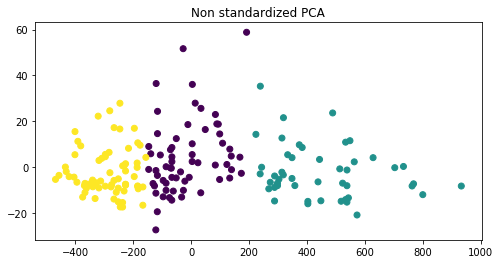

In [50]:
random_state = 170
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)

plt.figure(figsize=(8,4))
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Non standardized PCA")

Hmmm... This doesn't look great... we used PCA, guessed the *correct* number of clusters, but still it fails!


Let's repeat for the standardized data.

In [51]:
repeats = 10
kClusters = 10
data = X_std

criteriaAIC_BIC = np.zeros((repeats,2,kClusters))
for rep in np.arange(0,repeats):
    for nr in np.arange(1,kClusters):
        n_clusters=nr
        data
        model=mixture.GaussianMixture(n_components=n_clusters, init_params='kmeans')
        model.fit(data)
        criteriaAIC_BIC[rep,0,nr]=model.aic(data)
        criteriaAIC_BIC[rep,1,nr]=model.bic(data)

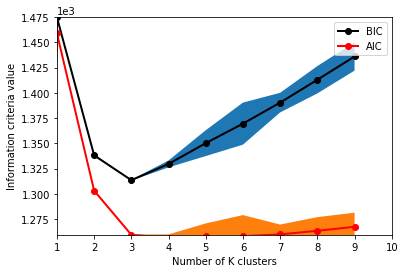

In [52]:
meanAIC = criteriaAIC_BIC[:, 0, 0:kClusters].mean(axis = 0)
stdAIC = criteriaAIC_BIC[:, 0, 0:kClusters].std(axis = 0)

meanBIC = criteriaAIC_BIC[:, 1, 0:kClusters].mean(axis = 0)
stdBIC = criteriaAIC_BIC[:, 1, 0:kClusters].std(axis = 0)

plt.plot(np.arange(0, kClusters),meanBIC, '-ok', label='BIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanBIC-2*stdBIC, meanBIC+2*stdBIC)

plt.plot(np.arange(0, kClusters),meanAIC, '-or', label='AIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanAIC-2*stdAIC, meanAIC+2*stdAIC)


plt.ylim(np.min(meanAIC[1:4]), np.max(meanBIC[0:4]))
plt.xlabel('Number of K clusters')
plt.ylabel('Information criteria value')
plt.legend()
plt.xlim(1,10)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('informationCriteriaAsymptoting_wError.png', format='png', dpi=500, bbox_inches='tight')  

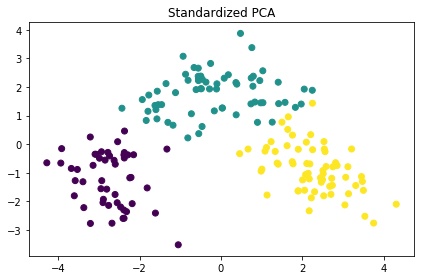

In [57]:
y_pred_std = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_std)


plt.scatter(X_std[:, 0], X_std[:, 1], c=y_pred_std)
plt.title("Standardized PCA")

plt.tight_layout()

plt.show()  

## Now one last time:

Standardizing is an amazing too, it's so simple, but makes such a difference!

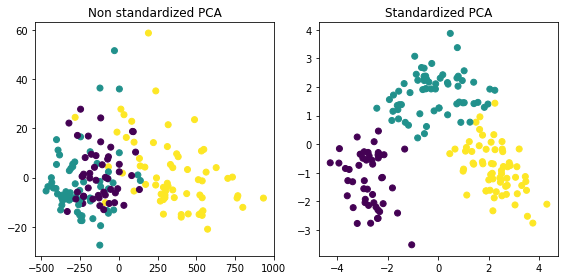

In [58]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Non standardized PCA")

plt.subplot(122)
plt.scatter(X_std[:, 0], X_std[:, 1], c=y_pred_std)
plt.title("Standardized PCA")

plt.tight_layout()

plt.show() 